In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 128
noise_dim = 100
epochs = 10

# Transformations applied to MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [3]:
# MNIST dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block_1 = get_disc_block(1,16,(3,3),2)
        self.block_2 = get_disc_block(16,32,(5,5),2)
        self.block_3 = get_disc_block(32,64,(5,5),2)
        
        self.flatten = nn.Flatten()
        
        self.linear = nn.Linear(in_features = 64, out_features= 1)
        
    def forward (self,images):
        # Creating connections for executing the blocks in order
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        
        return x5

D = Discriminator().to(device)

In [5]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim

        self.block_1 = get_gen_block(noise_dim, 256, 3, 2)
        self.block_2 = get_gen_block(256, 128, 4, 1)
        self.block_3 = get_gen_block(128, 64, 3, 2)
        self.block_4 = get_gen_block(64, 1, 4, 2, final_block=True)

    def forward(self, noise_vec):
        x = noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

G = Generator(noise_dim).to(device)


In [6]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply weight initialization to discriminator and generator
D.apply(weights_init)
G.apply(weights_init)

# Binary cross-entropy loss with sigmoid
criterion = nn.BCEWithLogitsLoss()

# Optimizers
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


 42%|████▏     | 199/469 [00:12<00:14, 19.15it/s]

Epoch [1/10], Step [200/469], D_loss: 1.2622, G_loss: 0.7778


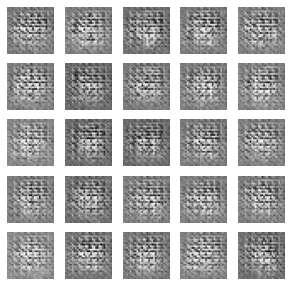

 85%|████████▍ | 397/469 [00:23<00:03, 19.88it/s]

Epoch [1/10], Step [400/469], D_loss: 1.2174, G_loss: 0.7995


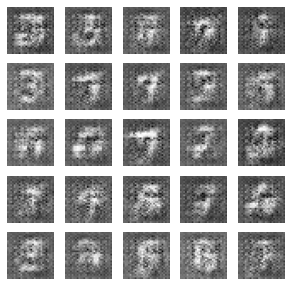

 42%|████▏     | 198/469 [00:10<00:13, 20.38it/s]

Epoch [2/10], Step [200/469], D_loss: 1.1108, G_loss: 0.9016


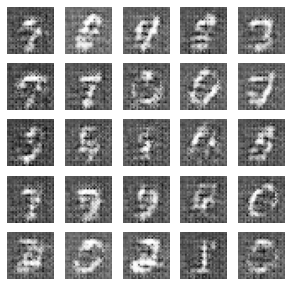

 85%|████████▌ | 399/469 [00:21<00:03, 19.12it/s]

Epoch [2/10], Step [400/469], D_loss: 1.0675, G_loss: 0.9554


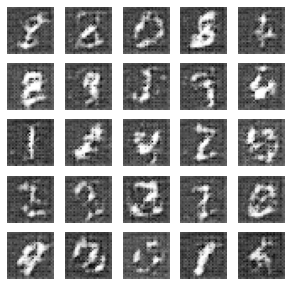

 42%|████▏     | 198/469 [00:09<00:12, 22.29it/s]

Epoch [3/10], Step [200/469], D_loss: 0.9530, G_loss: 1.0254


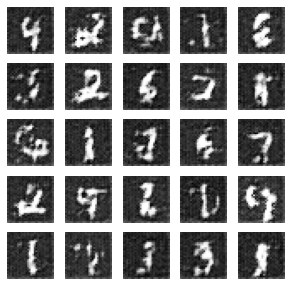

 85%|████████▌ | 399/469 [00:19<00:03, 21.85it/s]

Epoch [3/10], Step [400/469], D_loss: 0.9473, G_loss: 1.1340


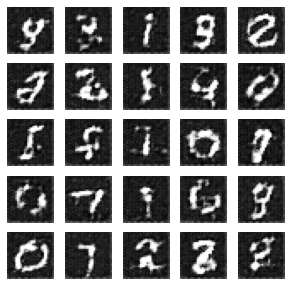

 42%|████▏     | 198/469 [00:09<00:13, 19.51it/s]

Epoch [4/10], Step [200/469], D_loss: 0.8921, G_loss: 1.2411


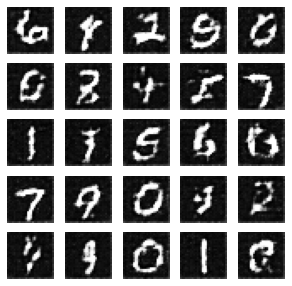

 85%|████████▌ | 399/469 [00:21<00:03, 18.17it/s]

Epoch [4/10], Step [400/469], D_loss: 0.9492, G_loss: 1.1346


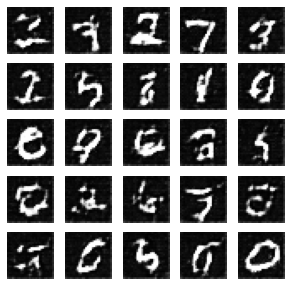

 42%|████▏     | 198/469 [00:10<00:14, 18.42it/s]

Epoch [5/10], Step [200/469], D_loss: 0.9546, G_loss: 1.0004


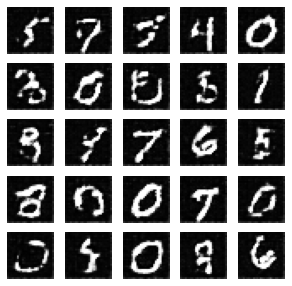

 85%|████████▍ | 398/469 [00:21<00:03, 19.15it/s]

Epoch [5/10], Step [400/469], D_loss: 0.9947, G_loss: 1.0829


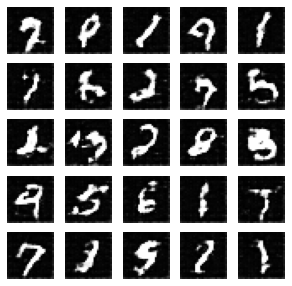

 42%|████▏     | 197/469 [00:09<00:12, 21.08it/s]

Epoch [6/10], Step [200/469], D_loss: 1.0430, G_loss: 1.2944


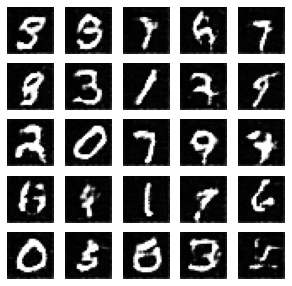

 85%|████████▍ | 398/469 [00:21<00:03, 18.36it/s]

Epoch [6/10], Step [400/469], D_loss: 0.9916, G_loss: 1.1603


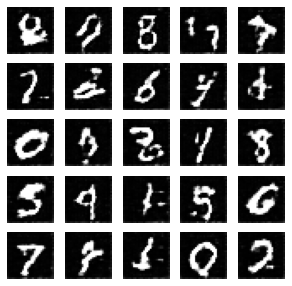

 42%|████▏     | 198/469 [00:11<00:15, 17.45it/s]

Epoch [7/10], Step [200/469], D_loss: 1.0161, G_loss: 1.0868


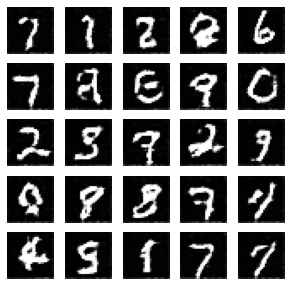

 85%|████████▍ | 398/469 [00:22<00:03, 20.46it/s]

Epoch [7/10], Step [400/469], D_loss: 1.0291, G_loss: 1.1230


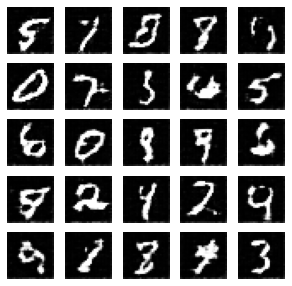

  6%|▌         | 29/469 [00:01<00:21, 20.50it/s]

In [ ]:
# Training loop
total_step = len(train_loader)

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(tqdm(train_loader)):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Train the discriminator with real images
        D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        real_outputs = D(real_images)
        D_real_loss = criterion(real_outputs, real_labels)

        # Train the discriminator with fake images
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake_images = G(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_outputs = D(fake_images.detach())
        D_fake_loss = criterion(fake_outputs, fake_labels)

        # Update discriminator weights
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        # Train the generator
        G.zero_grad()
        fake_outputs = D(fake_images)
        G_loss = criterion(fake_outputs, real_labels)

        # Update generator weights
        G_loss.backward()
        G_optimizer.step()

        # Print losses
        if (i + 1) % 200 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_step}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}"
                # Generate and visualize fake images
            )
            with torch.no_grad():
                noise = torch.randn(25, noise_dim, 1, 1).to(device)
                fake_images = G(noise)

            # Visualize generated images
            fig, axes = plt.subplots(5, 5, figsize=(5, 5))
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake_images[i].squeeze().cpu(), cmap="gray")
                ax.axis("off")

            plt.show()
            


In [ ]:
# Generate and visualize fake images
with torch.no_grad():
    noise = torch.randn(25, noise_dim, 1, 1).to(device)
    fake_images = G(noise)

# Visualize generated images
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i].squeeze().cpu(), cmap="gray")
    ax.axis("off")

plt.show()